In [1]:
"""from https://github.com/HeWeMel/nographs/discussions/12, Computing strongly connected components"""

'from https://github.com/HeWeMel/nographs/discussions/12, Computing strongly connected components'

In [2]:
import nographs as nog
from graphviz import Digraph

In [3]:
dict_1= {0:{111,2,4}, 111:{3,5}, 2:{3,6,0}, 3:{37,0}, 37:{7}, 4:{5,6}, 5:{57}, 57:{7},
         6:{67}, 67:{7}, 7:{6} }

In [11]:
def adapter_graphviz( to_deco ):
    """translation to GraphViz visitor"""
    dot = Digraph()
    def wrapper_bg( vert, _traversal_context ):
        """visitor wrapper"""
        dot.node( str( vert ), str( vert ) )
        print( 'v  ', (_traversal_context.visited) )
        print( 'pc ', (_traversal_context.paths._predecessor_collection) )
        print( 'p. ', (_traversal_context.paths._predecessor) )
        for result in to_deco( vert, _traversal_context ):
            dot.edge( str( vert ), str( result ), )
            yield result
    wrapper_bg.dot = dot
    return wrapper_bg

@adapter_graphviz
def forward( vert, _):
    """wrapping the dict as `next_vertices` visitor function"""
    return dict_1[ vert ]

In [12]:
trav_forward = nog.TraversalBreadthFirst( forward )
trav_forward.start_from( 0, build_paths=True )
list(trav_forward)

v   {0}
pc  {0: 0}
p.  {0: 0}
v   {0, 2, 4, 111}
pc  {0: 0, 2: 0, 4: 0, 111: 0}
p.  {0: 0, 2: 0, 4: 0, 111: 0}
v   {0, 2, 3, 4, 6, 111}
pc  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2}
p.  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2}
v   {0, 2, 3, 4, 5, 6, 111}
pc  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4}
p.  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4}
v   {0, 2, 3, 4, 5, 6, 111}
pc  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4}
p.  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4}
v   {0, 2, 3, 4, 5, 6, 37, 111}
pc  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4, 37: 3}
p.  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4, 37: 3}
v   {0, 2, 3, 4, 5, 6, 37, 67, 111}
pc  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4, 37: 3, 67: 6}
p.  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4, 37: 3, 67: 6}
v   {0, 2, 3, 4, 5, 6, 37, 67, 111, 57}
pc  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4, 37: 3, 67: 6, 57: 5}
p.  {0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4, 37: 3, 67: 6, 57: 5}
v   {0, 2, 3, 4, 5, 6, 37, 67, 7, 111, 5

[2, 4, 111, 3, 6, 5, 37, 67, 57, 7]

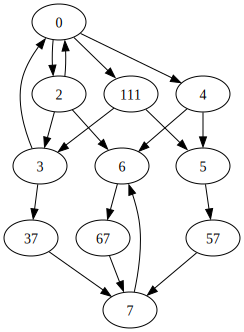

In [6]:
forward.dot              # pylint: disable=pointless-statement

In [7]:
#(trav_forward.paths._predecessor_collection)

{0: 0, 2: 0, 4: 0, 111: 0, 3: 2, 6: 2, 5: 4, 37: 3, 67: 6, 57: 5, 7: 37}

In [8]:
#dir(trav_forward.paths)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__orig_class__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_vertex',
 '_is_protocol',
 '_iter_raw_edges_to_start',
 '_predecessor',
 '_predecessor_collection',
 '_predecessor_wrapper',
 '_vertex_to_id',
 'append_edge',
 'iter_edges_from_start',
 'iter_edges_to_start',
 'iter_labeled_edges_from_start',
 'iter_labeled_edges_to_start',
 'iter_vertices_from_start',
 'iter_vertices_to_start']